# PREDICCIÓN DEL PRECIOS DE ACTIVOS EMPLEANDO APRENDIZAJE AUTOMÁTICO
#### Autor: Samuel Valer Nasta

Apuntes previos:

1. Red neuronal para varios activos.
2. Probar con otros valores, en este caso.
3. Ajustar modelo hasta 2018 y ver como diverge en la caida del 2019.
4. Aplicar corss valdiation y anlaizar cada una de las iteraciones.
5. Amalisis de PCAs.
6. Tomar precio ajustado de los sotcks para ajustar pagos de dividendos (adj price).
7. ahora hacer preproc de datos y luego reptir red neuronal con CV

# Librerías empleadas

In [247]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Obtención y análisis de datos

In [248]:
fecha_inicio = '2010-01-01'
fecha_fin = '2023-12-31'

datos_tesla = yf.download('TSLA', start=fecha_inicio, end=fecha_fin)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio, end=fecha_fin)
datos_santander = yf.download('SAN.MC', start=fecha_inicio, end=fecha_fin)
datos_petroleo = yf.download('CL=F', start=fecha_inicio, end=fecha_fin)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Preprocesamiento de datos

In [249]:
datos_tesla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


Comprobamos si hay datos nulos o na.

In [250]:
print(datos_tesla.isnull().sum())
print(datos_tesla.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [251]:
print(datos_sp500.isnull().sum())
print(datos_sp500.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [252]:
print(datos_santander.isnull().sum())
print(datos_santander.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [253]:
print(datos_petroleo.isnull().sum())
print(datos_petroleo.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


## Representación gráfica

### Gráfico de lineas

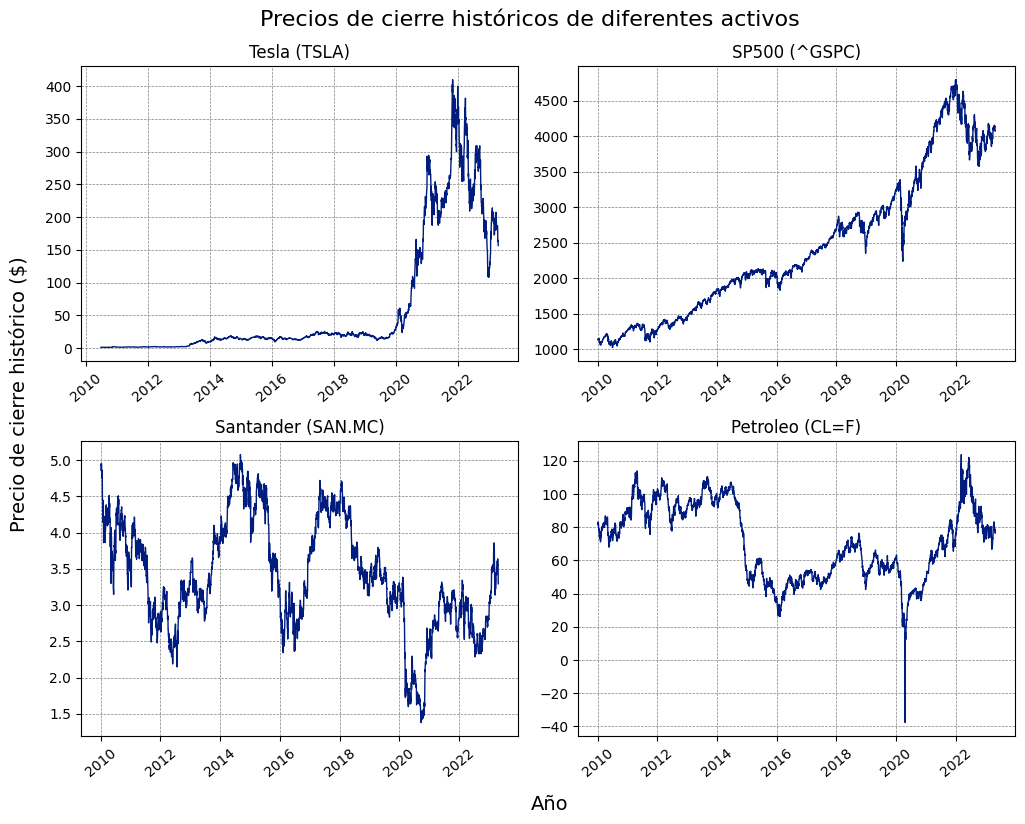

In [254]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(datos_tesla['Adj Close'], linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(datos_sp500['Adj Close'], linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(datos_santander['Adj Close'], linewidth=1)
axs[1, 0].set_title('Santander (SAN.MC)')
axs[1, 1].plot(datos_petroleo['Adj Close'], linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio de cierre histórico ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Precios de cierre históricos de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()


Aqui vemos como en 2018 hubo un problema por lo que lo vamos a prescindir de estos datos.

### Gráfico de lineas de todas las variables de cada activo en una temporalidad menor

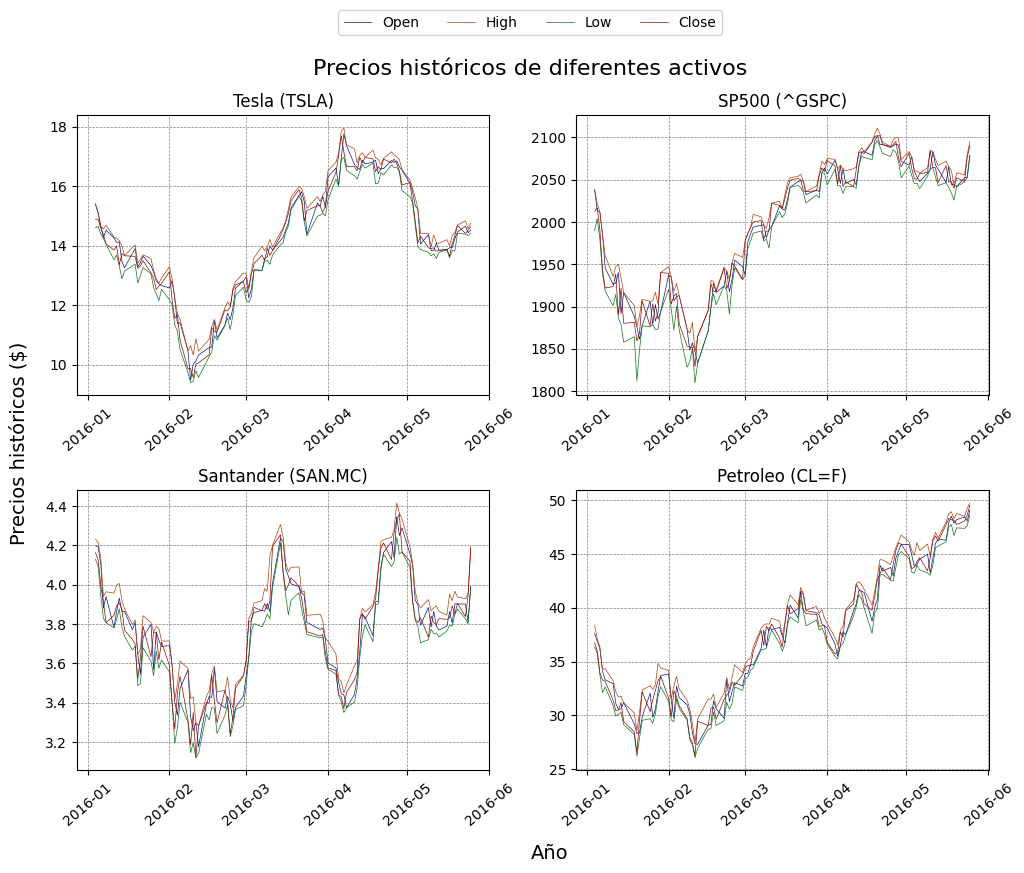

In [255]:
sns.set_palette('dark')

fecha_inicio_plot = '2016-01-01'
fecha_fin_plot = '2016-05-25'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axs = axs.flatten()

datos = [datos_tesla, datos_sp500, datos_santander, datos_petroleo]
titulos = ['Tesla (TSLA)', 'SP500 (^GSPC)', 'Santander (SAN.MC)', 'Petroleo (CL=F)']
etiquetas = ['Open', 'High', 'Low', 'Close']  # etiquetas para la leyenda

for i, ax in enumerate(axs):
    ax.set_title(titulos[i])
    for j, etiqueta in enumerate(etiquetas):
        ax.plot(datos[i].loc[fecha_inicio_plot:fecha_fin_plot, etiqueta], linewidth=0.5, label=etiqueta)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precios históricos ($)', va='center', rotation='vertical', fontsize=14) 
fig.suptitle('Precios históricos de diferentes activos', fontsize=16)

fig.legend(etiquetas, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Retornos diarios

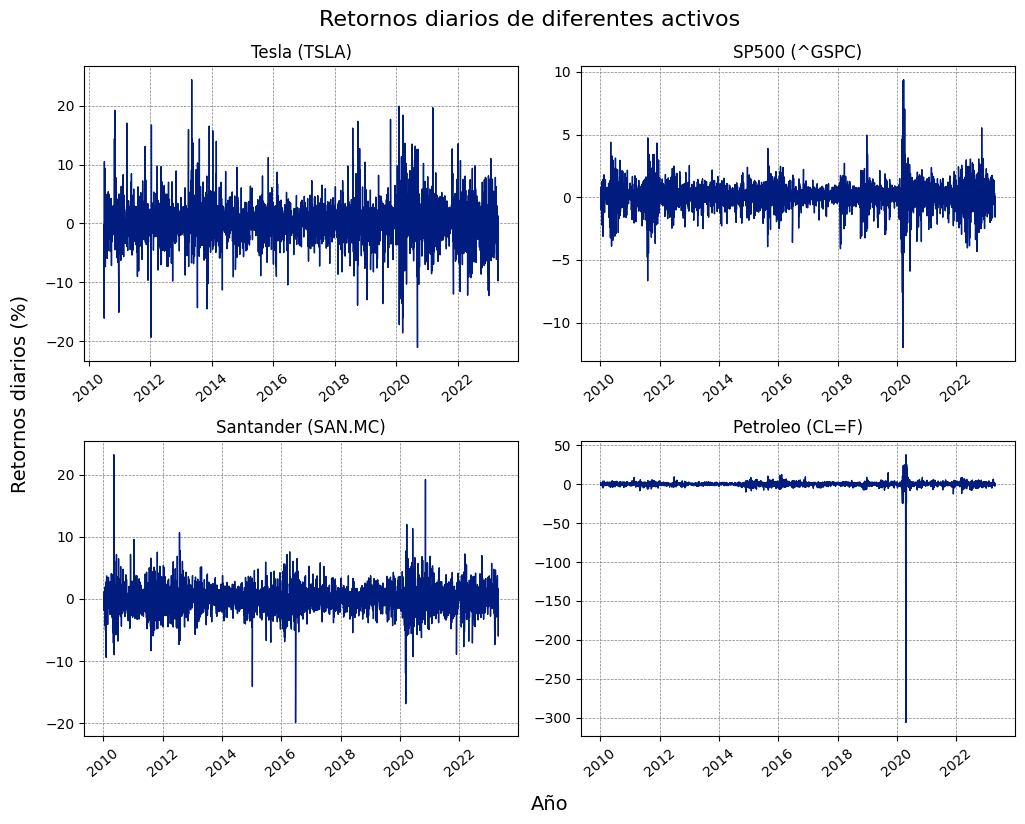

In [256]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(datos_tesla['Adj Close'].pct_change()*100, linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(datos_sp500['Adj Close'].pct_change()*100, linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(datos_santander['Adj Close'].pct_change()*100, linewidth=1)
axs[1, 0].set_title('Santander (SAN.MC)')
axs[1, 1].plot(datos_petroleo['Adj Close'].pct_change()*100, linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Retornos diarios (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Retornos diarios de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()


### Volatilidad en ventanas de 15 dias

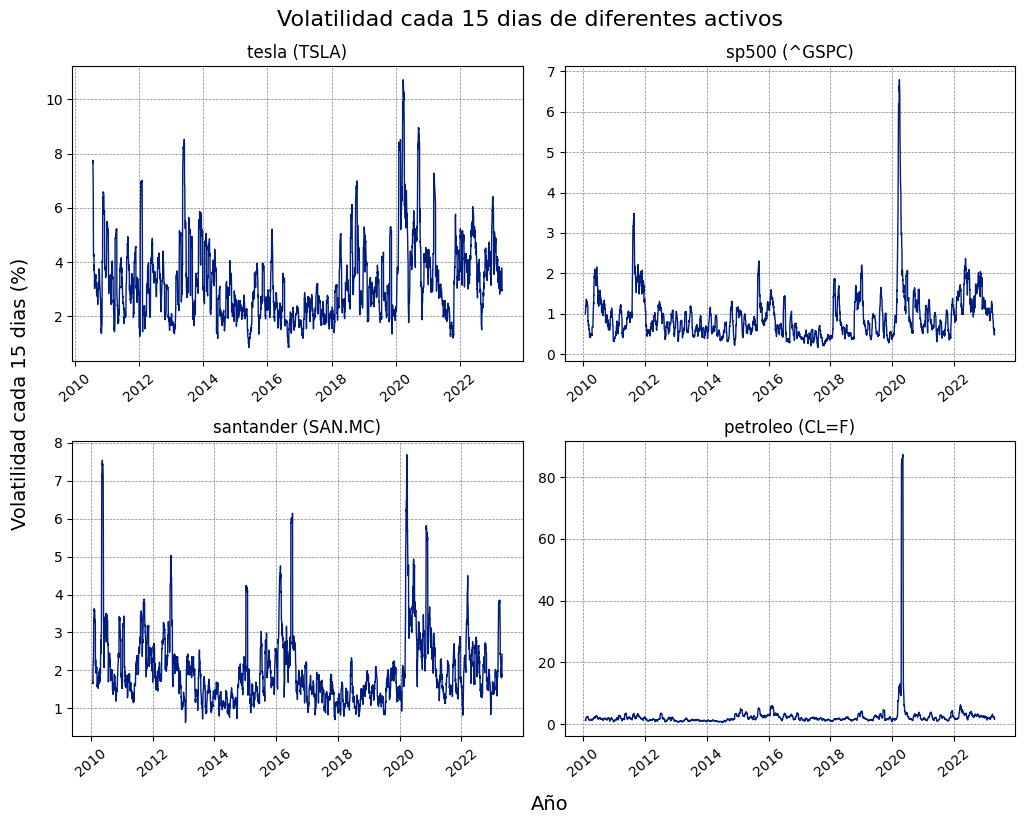

In [257]:
sns.set_palette('dark')

# Calcular la volatilidad diaria en ventanas de tiempo
window = 15
volatility_tesla = datos_tesla['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_sp500 = datos_sp500['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_santander = datos_santander['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_petroleo = datos_petroleo['Adj Close'].pct_change().rolling(window=window).std() * 100

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(volatility_tesla, linewidth=1)
axs[0, 0].set_title('tesla (TSLA)')
axs[0, 1].plot(volatility_sp500, linewidth=1)
axs[0, 1].set_title('sp500 (^GSPC)')
axs[1, 0].plot(volatility_santander, linewidth=1)
axs[1, 0].set_title('santander (SAN.MC)')
axs[1, 1].plot(volatility_petroleo, linewidth=1)
axs[1, 1].set_title('petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)
fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Volatilidad cada 15 dias (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Volatilidad cada 15 dias de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()

### Máximo Drawdown en 15 dias

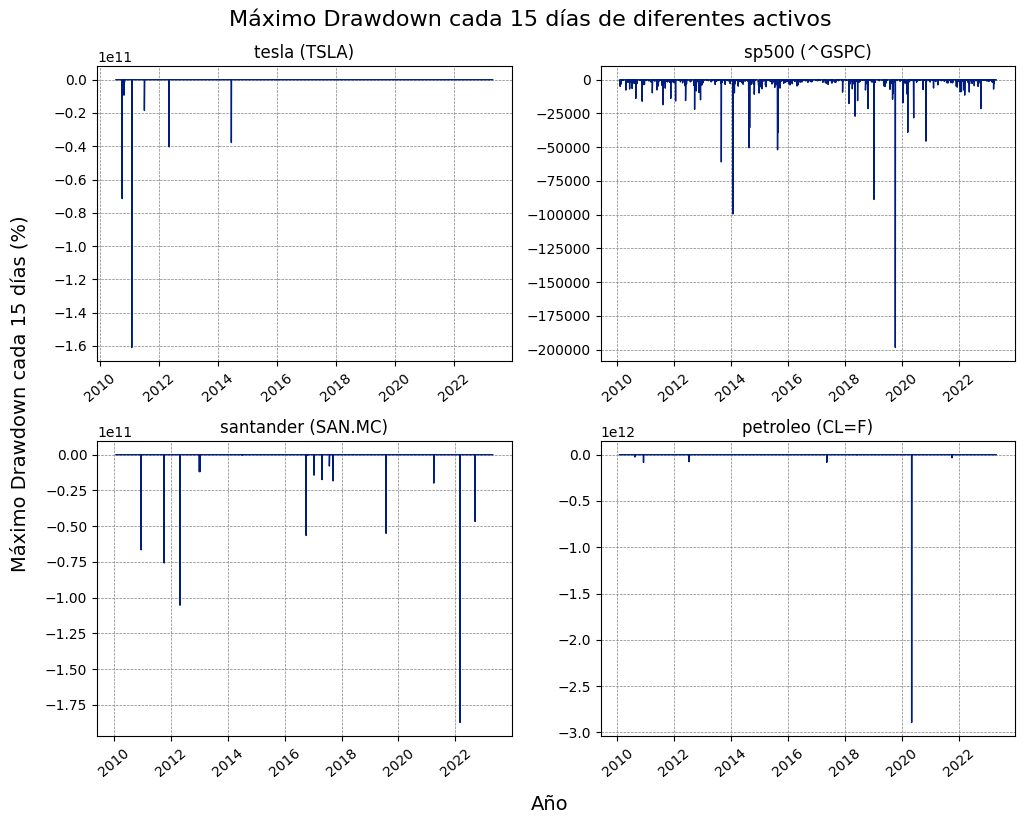

In [258]:
def max_drawdown(data):
    """
    Función para calcular el Máximo Drawdown de un conjunto de datos.
    """
    cum_returns = np.cumprod(1 + data) - 1
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / (peak + 1e-10)
    max_drawdown = drawdown.min()
    return max_drawdown

# Calcular el Máximo Drawdown en ventanas de tiempo de 15 días
window = 15
max_drawdown_tesla = datos_tesla['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_sp500 = datos_sp500['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_santander = datos_santander['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_petroleo = datos_petroleo['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(max_drawdown_tesla, linewidth=1)
axs[0, 0].set_title('tesla (TSLA)')
axs[0, 1].plot(max_drawdown_sp500, linewidth=1)
axs[0, 1].set_title('sp500 (^GSPC)')
axs[1, 0].plot(max_drawdown_santander, linewidth=1)
axs[1, 0].set_title('santander (SAN.MC)')
axs[1, 1].plot(max_drawdown_petroleo, linewidth=1)
axs[1, 1].set_title('petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)
fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Máximo Drawdown cada 15 días (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Máximo Drawdown cada 15 días de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()

### Mapa de calor

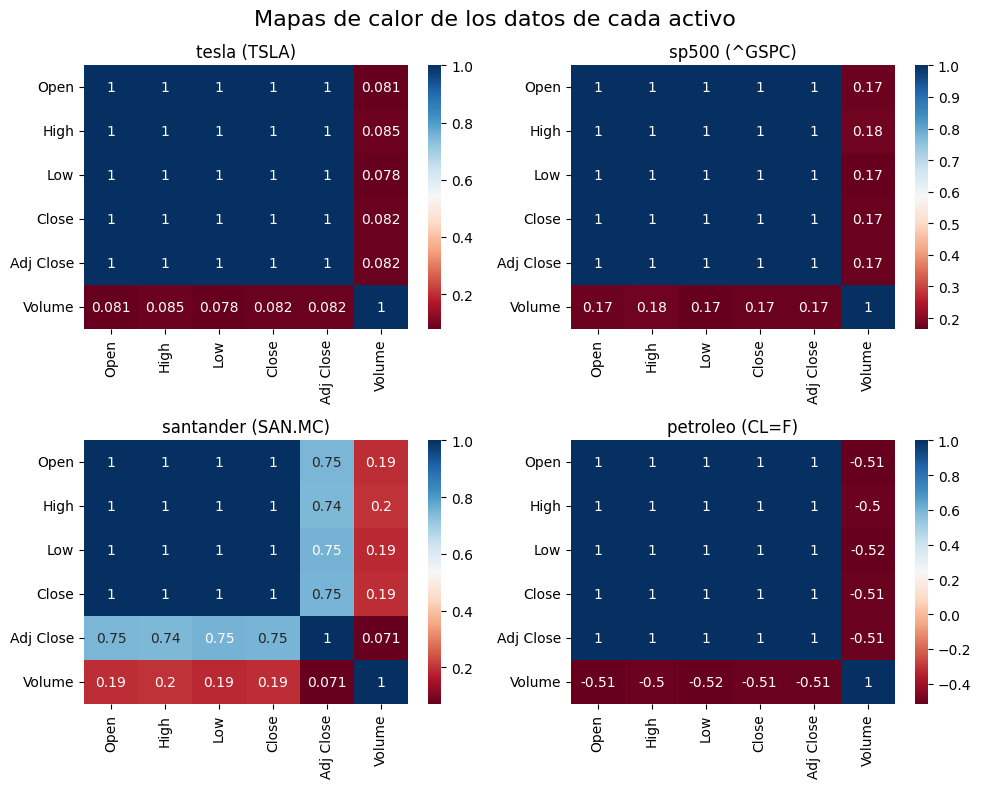

In [259]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.heatmap(datos_tesla.corr(), annot=True, cmap="RdBu", ax=axs[0, 0])
axs[0, 0].set_title('tesla (TSLA)')
sns.heatmap(datos_sp500.corr(), annot=True, cmap="RdBu", ax=axs[0, 1])
axs[0, 1].set_title('sp500 (^GSPC)')
sns.heatmap(datos_santander.corr(), annot=True, cmap="RdBu", ax=axs[1, 0])
axs[1, 0].set_title('santander (SAN.MC)')
sns.heatmap(datos_petroleo.corr(), annot=True, cmap="RdBu", ax=axs[1, 1])
axs[1, 1].set_title('petroleo (CL=F)')

fig.suptitle('Mapas de calor de los datos de cada activo', fontsize=16)

plt.tight_layout()
plt.show()

# Preparación de los datos

In [260]:
fecha_inicio = '2010-01-01'
fecha_fin = '2017-12-31'

datos_tesla = yf.download('TSLA', start=fecha_inicio, end=fecha_fin)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio, end=fecha_fin)
datos_santander = yf.download('SAN.MC', start=fecha_inicio, end=fecha_fin)
datos_petroleo = yf.download('CL=F', start=fecha_inicio, end=fecha_fin)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Creamos un dataframe nuevo con solo el precio de cierre.

In [261]:
datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_santander = datos_santander.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

Normalizamos / escalamos las variables para que tomen valor entre 0 y 1

In [262]:
scaler = MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_santander = scaler.fit_transform(np.array(datos_santander).reshape(-1,1))
datos_petroleo = scaler.fit_transform(np.array(datos_petroleo).reshape(-1,1))
# X_test =scaler.transform(X_test)
print(datos_tesla.shape,
      datos_sp500.shape,
      datos_santander.shape,
      datos_petroleo.shape)

(1891, 1) (2013, 1) (2047, 1) (2011, 1)


Definimos una función para crear datos de train y test

In [263]:
def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla



Creamos los dataset, los dividimos en train y test luego los escalamos:

In [264]:
def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train

In [265]:
pasos = 10  # Número de pasos de tiempo en cada ventana
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos)
y_santander, x_santander = create_time_series_dataset(datos_santander, pasos)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos)

# Preparar datos de entrenamiento para Santander
x_train_santander, y_train_santander, x_train_santander_reg, y_train_santander_reg = preparar_datos_entrenamiento(datos_santander, pasos)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos)

# Imprimir dimensiones de los datos de entrenamiento preparados
print("Dimensiones de los datos de entrenamiento de Tesla:")
print("x_train_tesla:", x_train_tesla.shape)
print("y_train_tesla:", y_train_tesla.shape)
print("x_train_tesla_reg:", x_train_tesla_reg.shape)
print('\n')

print("Dimensiones de los datos de entrenamiento de S&P 500:")
print("x_train_sp500:", x_train_sp500.shape)
print("y_train_sp500:", y_train_sp500.shape)
print("x_train_sp500_reg:", x_train_sp500_reg.shape)
print('\n')

print("Dimensiones de los datos de entrenamiento de Santander:")
print("x_train_santander:", x_train_santander.shape)
print("y_train_santander:", y_train_santander.shape)
print("x_train_santander_reg:", x_train_santander_reg.shape)
print('\n')

print("Dimensiones de los datos de entrenamiento de petróleo:")
print("x_train_petroleo:", x_train_petroleo.shape)
print("y_train_petroleo:", y_train_petroleo.shape)
print("x_train_petroleo_reg:", x_train_petroleo_reg.shape)
print('\n')


Dimensiones de los datos de entrenamiento de Tesla:
x_train_tesla: (1881, 10, 1)
y_train_tesla: (1881, 1)
x_train_tesla_reg: (1881, 10)


Dimensiones de los datos de entrenamiento de S&P 500:
x_train_sp500: (2003, 10, 1)
y_train_sp500: (2003, 1)
x_train_sp500_reg: (2003, 10)


Dimensiones de los datos de entrenamiento de Santander:
x_train_santander: (2037, 10, 1)
y_train_santander: (2037, 1)
x_train_santander_reg: (2037, 10)


Dimensiones de los datos de entrenamiento de petróleo:
x_train_petroleo: (2001, 10, 1)
y_train_petroleo: (2001, 1)
x_train_petroleo_reg: (2001, 10)




Descagramos datos nuevos para gráficar y hacer pruebas.

In [266]:
fecha_inicio = '2022-01-01'
fecha_fin = '2023-01-01'

datos_tesla_test = yf.download('TSLA', start=fecha_inicio, end=fecha_fin)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio, end=fecha_fin)
datos_santander_test = yf.download('SAN.MC', start=fecha_inicio, end=fecha_fin)
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio, end=fecha_fin)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_santander_test = datos_santander_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_santander_test = scaler.transform(np.array(datos_santander_test).reshape(-1,1))
datos_petroleo_test = scaler.transform(np.array(datos_petroleo_test).reshape(-1,1))

pasos = 10 # TODO: Justificar en la memoria, los dias van de 5 en 5 probar con 10-25 
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_santander_t, x_santander_t = create_time_series_dataset(datos_santander_test, pasos)
x_santander_t_reg = x_santander_t.reshape(x_santander_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# PREGUNTAS PARA LOS DIRECTORES

1. Esta bien la normalización? esta hecho así para asegurarse de que todas las variables estén en la misma escala y evitar posibles sesgos en el modelo de predicción. 
2. Con que calculo los riesgos: Volatilidad 15 dais o Máximo Drawdown 15 dias
3. Definir BIEN fechas para train y para test 


# Modelos de aprendizaje automático

Usaremos las sigueintes métricas para evaluar los modelos:
   * RMSE (raíz del error cuadrático medio): esta métrica es útil para evaluar la precisión de la predicción del modelo en la misma escala que los valores de la variable objetivo.

   * MSE (error cuadrático medio): al igual que el RMSE, el MSE mide la precisión de la predicción del modelo. Sin embargo, como los errores están al cuadrado, el MSE puede dar más peso a los errores grandes.

   * MAE (error absoluto medio): esta métrica es una buena opción para evaluar la precisión de la predicción en una escala fácil de interpretar. El MAE es la media de las diferencias absolutas entre las predicciones y los valores reales.

   * R2 SCORE (coeficiente de determinación): esta métrica mide la proporción de la varianza en los valores de la variable objetivo que se explica por el modelo. Es una medida útil para evaluar el ajuste del modelo en general.


### Evaluación de los modelos

In [267]:
def evaluate_model(y_pred, y_test, name, ax):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name)
    ax.set_title(name)


### Funciones para las predicciones continuas

In [268]:
def evaluate_model_seguidos(y_pred, y_test, name, ax, dias):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[0:dias], label=name)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:dias], label=name)
    ax.set_title(name)


In [269]:
def calcula_dias(numero_dias, tam_ventana, dias_totales):
    """
    Calcula el número total de días necesarios para realizar una operación de ventana deslizante en una serie temporal.

    Parámetros:
        - numero_dias (int): Número total de días que se desean cubrir con la ventana deslizante.
        - tam_ventana (int): Tamaño de la ventana deslizante.
        - dias_totales (int): Número acumulado de días totales.

    Retorna:
        int: Número total de días necesarios para realizar la operación de ventana deslizante.
    """
    
    # Si ambos numero_dias y tam_ventana son mayores a 0, se suman al total de dias_totales
    if numero_dias > 0 and tam_ventana > 0:
        dias_totales += tam_ventana
    else:
        return dias_totales # Si alguno de los valores es menor o igual a 0, se retorna el valor actual de dias_totales
    return calcula_dias(numero_dias - 1, tam_ventana - 1, dias_totales) # Se llama recursivamente a la función con los valores reducidos en 1



In [270]:
def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy


## Regresión Lineal

### Entrenamiento

In [271]:
model_lr_tesla = LinearRegression()
model_lr_tesla.fit(x_train_tesla_reg, y_train_tesla)

model_lr_sp500 = LinearRegression()
model_lr_sp500.fit(x_train_sp500_reg, y_train_sp500)

model_lr_santander = LinearRegression()
model_lr_santander.fit(x_train_santander_reg, y_train_santander)

model_lr_petroleo = LinearRegression()
model_lr_petroleo.fit(x_train_petroleo_reg, y_train_petroleo)


LinearRegression()

### Comparación entre el precio predicho y el precio de cierre ajustado real (día siguiente)

Tesla (TSLA)
RMSE:  10.746114341109559
MSE:  115.47897343220053
MAE:  8.085409856440089
R²:  0.9613934604666514


SP500 (^GSPC)
RMSE:  63.11968921293841
MSE:  3984.0951663379333
MAE:  50.20384910478324
R²:  0.9453548774586846


Santander (SAN.MC)
RMSE:  0.40347476554902756
MSE:  0.16279188643484277
MAE:  0.3986564744007798
R²:  -1.7562433785492604


Petroleo (CL=F)
RMSE:  3.0853221972911644
MSE:  9.51921306109758
MAE:  2.3307609459034744
R²:  0.936203606993405




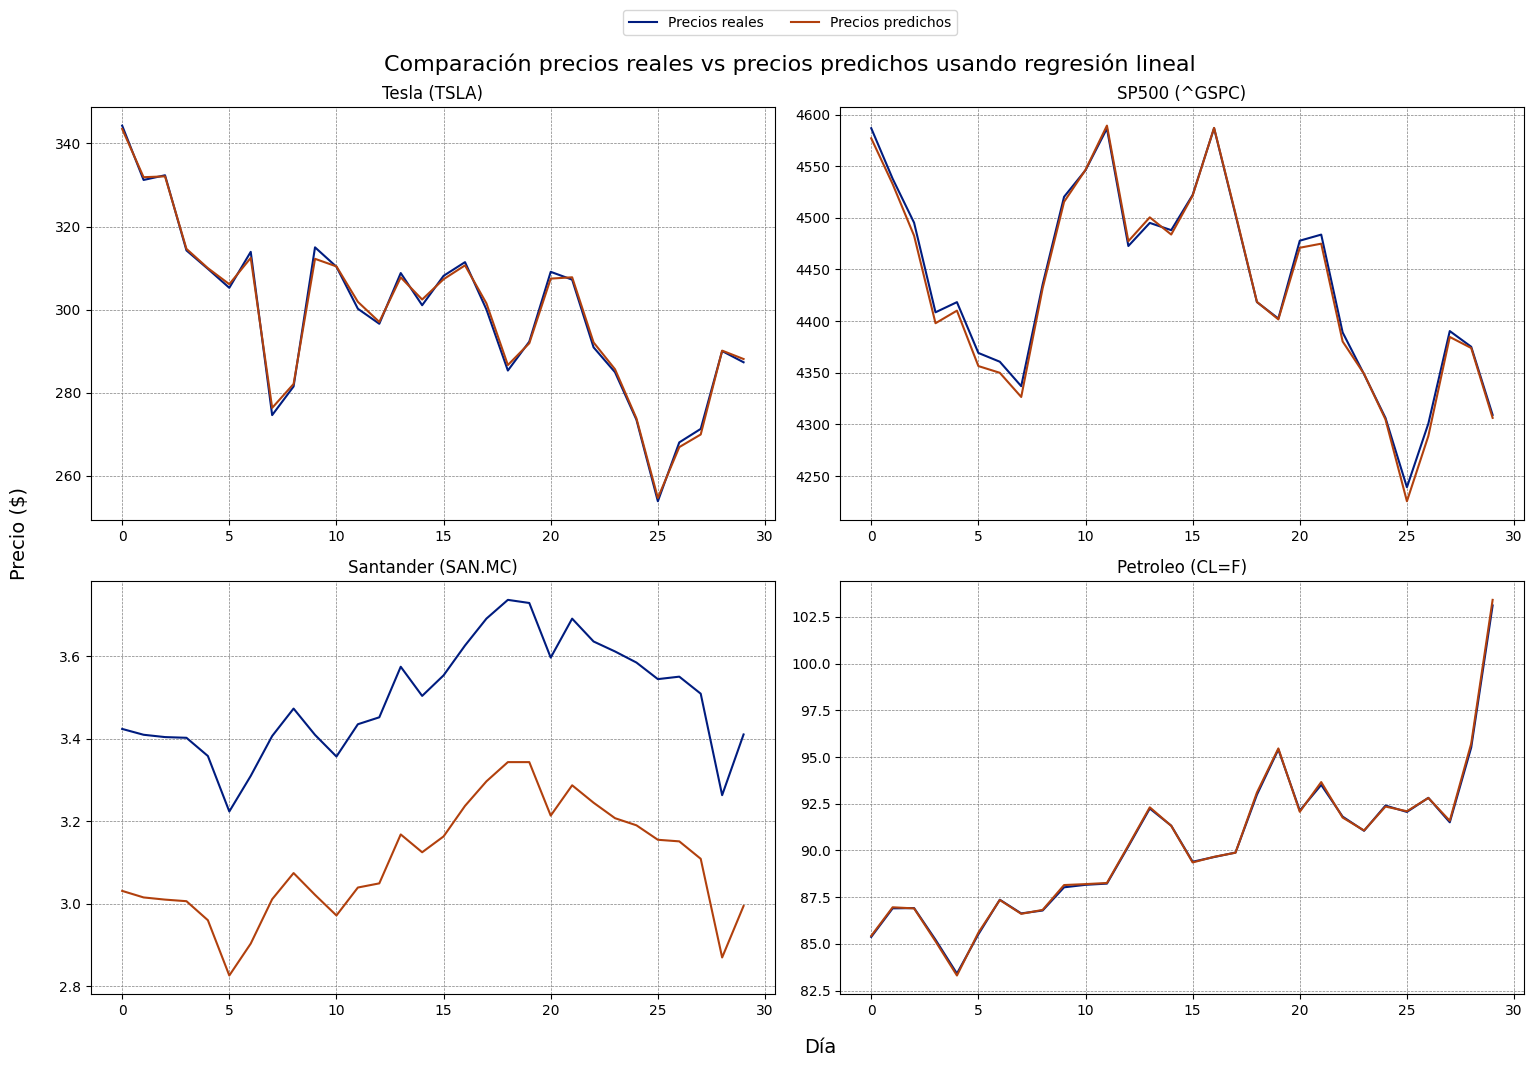

In [272]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_lr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0])

y_pred_sp500_t = model_lr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1])

y_pred_santander_t = model_lr_santander.predict(x_santander_t_reg)
evaluate_model(y_pred_santander_t, y_santander_t, "Santander (SAN.MC)", axs[1, 0])

y_pred_petroleo_t = model_lr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1])

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal', fontsize=16)
fig.legend(['Precios reales', 'Precios predichos'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 5 días

Tesla (TSLA)
RMSE:  26.61645260956422
MSE:  708.4355495171781
MAE:  23.455825751353427
R²:  -4828.943011640905


SP500 (^GSPC)
RMSE:  207.12388561368394
MSE:  42900.30399171043
MAE:  193.0335029442882
R²:  -1141.2666375675888


Santander (SAN.MC)
RMSE:  1.3135522060111733
MSE:  1.7254193979168195
MAE:  1.193908941234588
R²:  -5.226622151140451


Petroleo (CL=F)
RMSE:  2.232857461434097
MSE:  4.98565244308192
MAE:  1.9715292309532544
R²:  -12283.136393933817




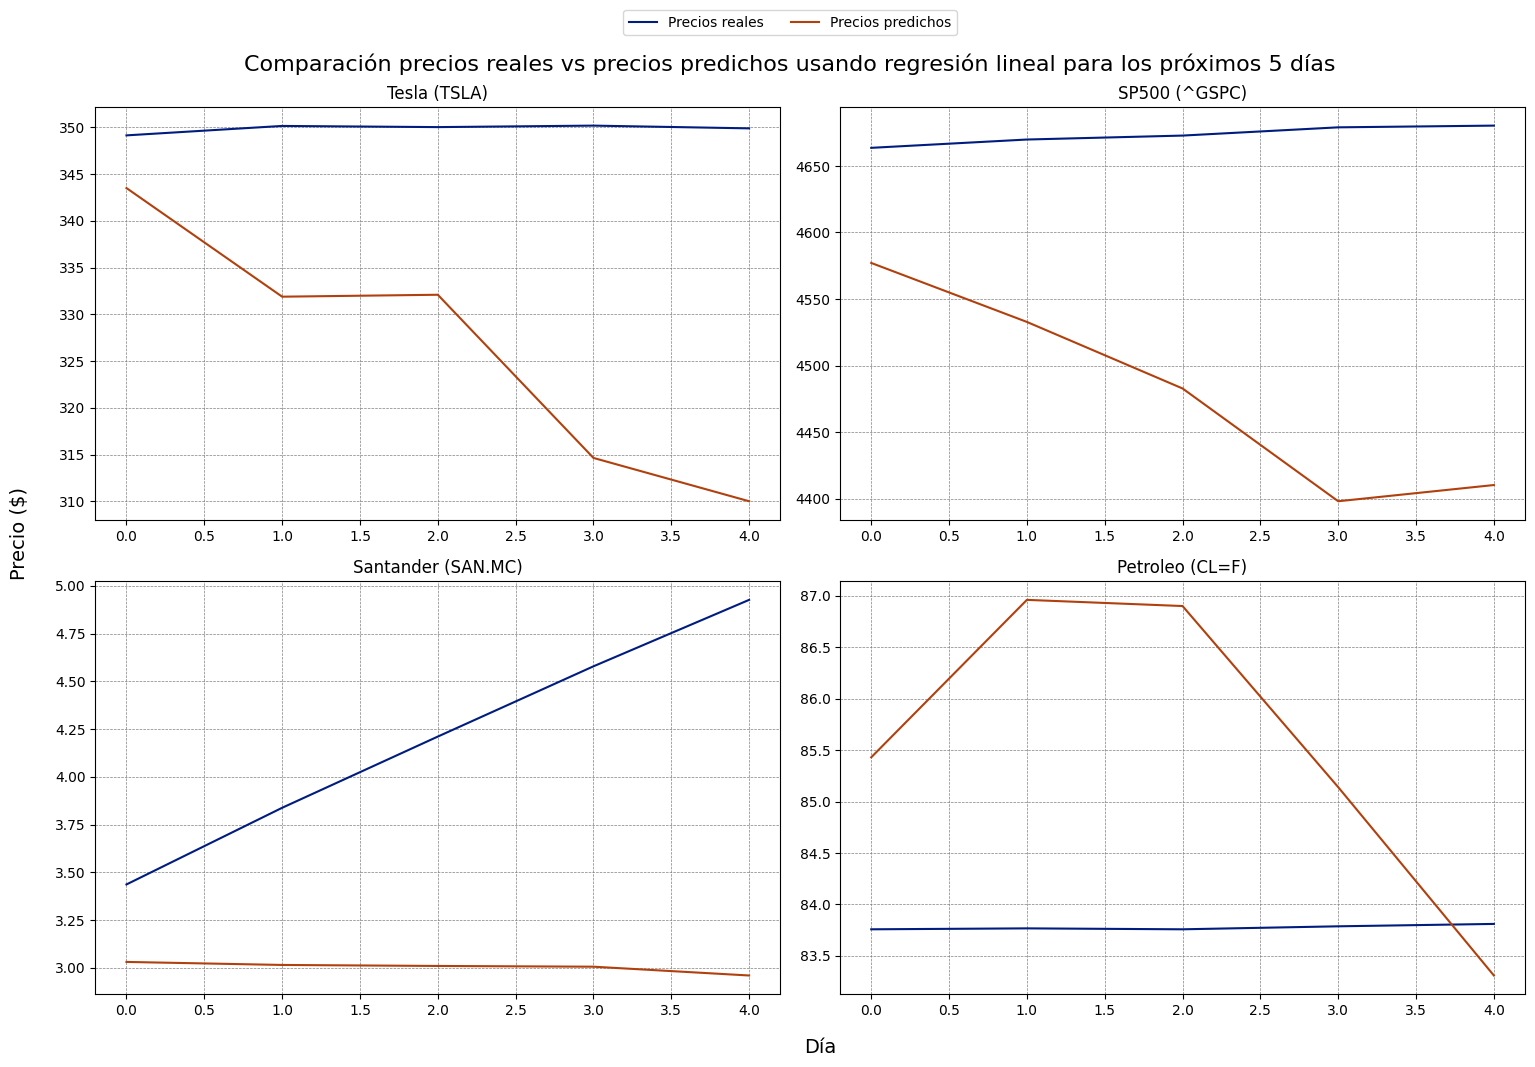

In [273]:
ventana = 10
dias = 5

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], dias)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], dias)

y_pred_santander_t = predict_n_days(datos_santander_test[0:ventana], ventana, dias, model_lr_santander)
evaluate_model_seguidos(y_pred_santander_t, y_santander_t[0:dias], "Santander (SAN.MC)", axs[1, 0], dias)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], dias)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 5 días', fontsize=16)
fig.legend(['Precios reales', 'Precios predichos'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  43.027412951821546
MSE:  1851.3582653265807
MAE:  39.64176561288511
R²:  -2764.8038457061766


SP500 (^GSPC)
RMSE:  231.69813283505368
MSE:  53684.02475925018
MAE:  217.04433100730154
R²:  -806.7862381545921


Santander (SAN.MC)
RMSE:  3.2720664331554072
MSE:  10.70641874298235
MAE:  2.9273882058854275
R²:  -3.7717993477984386


Petroleo (CL=F)
RMSE:  4.401569586351715
MSE:  19.373814823496406
MAE:  3.7952479495533256
R²:  -9412.15113619828




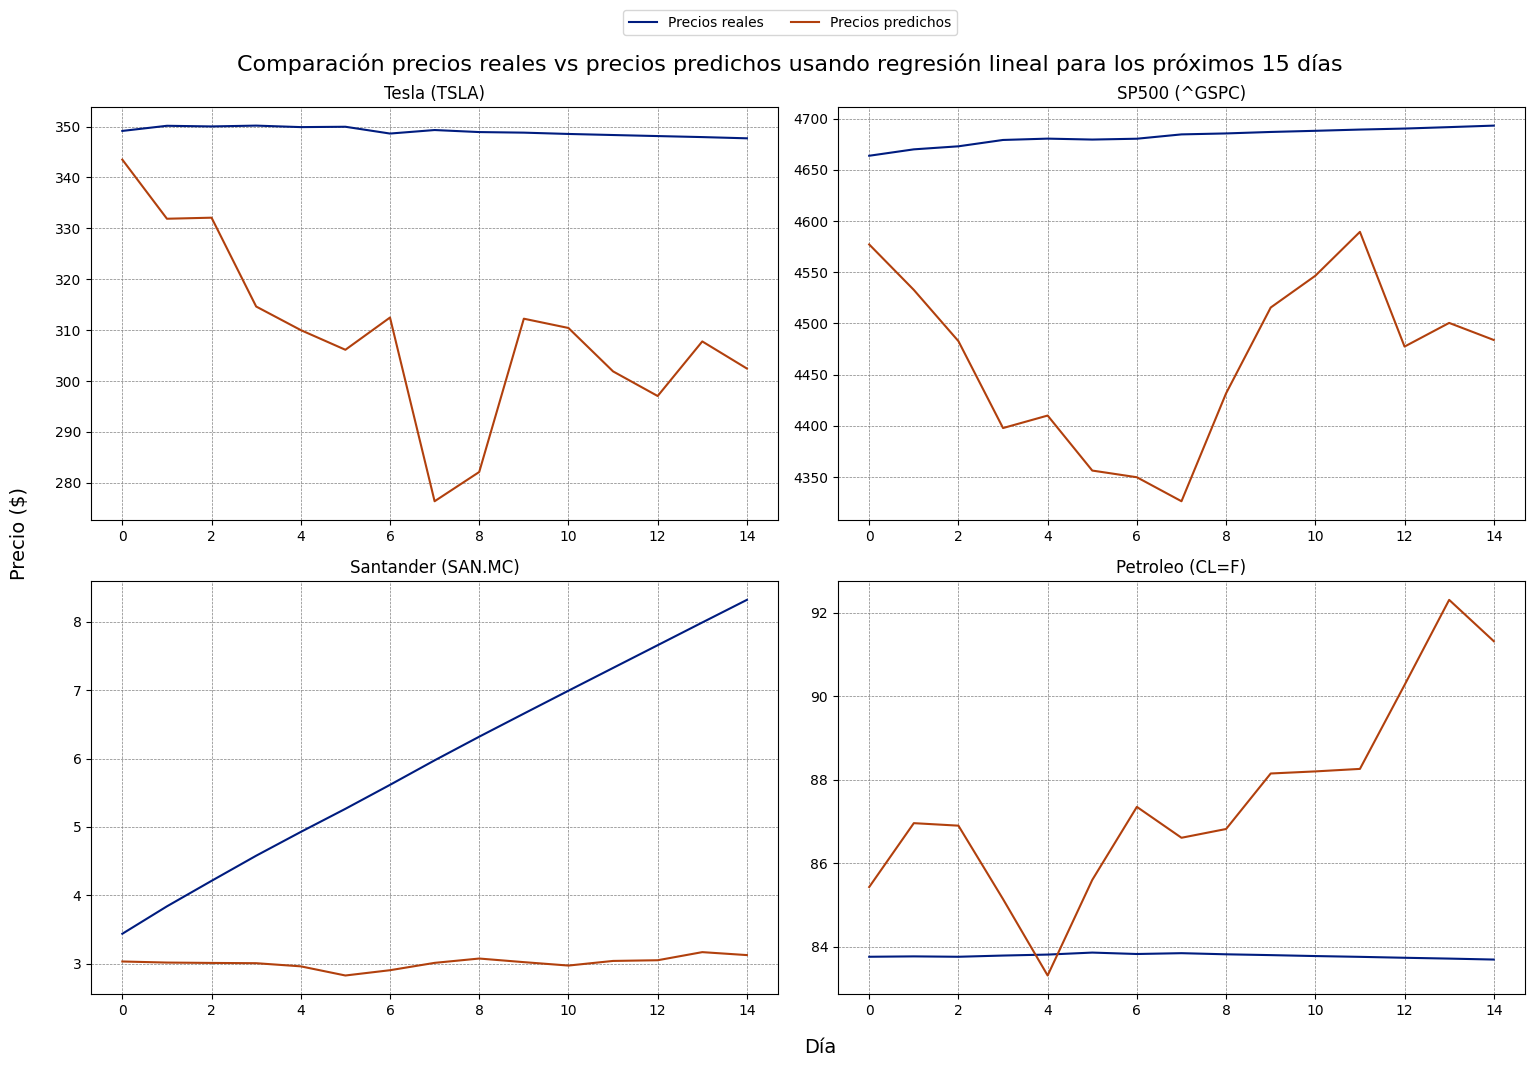

In [274]:
ventana = 10
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], dias)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], dias)

y_pred_santander_t = predict_n_days(datos_santander_test[0:ventana], ventana, dias, model_lr_santander)
evaluate_model_seguidos(y_pred_santander_t, y_santander_t[0:dias], "Santander (SAN.MC)", axs[1, 0], dias)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], dias)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios reales', 'Precios predichos'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

## SVR

In [296]:
model_svr_tesla = SVR(kernel='rbf', C= 20000, gamma= 0.0001)
model_svr_tesla.fit(x_train_tesla_reg, np.ravel(y_train_tesla))

model_svr_sp500 = SVR(kernel='rbf', C= 11213, gamma= 10)
model_svr_sp500.fit(x_train_sp500_reg, np.ravel(y_train_sp500))

model_svr_santander = SVR(kernel='rbf', C= 10000, gamma= 0.01)
model_svr_santander.fit(x_train_santander_reg, np.ravel(y_train_santander))

model_svr_petroleo = SVR(kernel='rbf', C= 20000, gamma= 0.0001)
model_svr_petroleo.fit(x_train_petroleo_reg, np.ravel(y_train_petroleo))

SVR(C=20000, gamma=0.0001)

Tesla (TSLA)
RMSE:  25.841269021043797
MSE:  667.7711846179578
MAE:  21.20069206212512
R²:  0.6739092437606498


SP500 (^GSPC)
RMSE:  4012.277921912382
MSE:  16098374.122665545
MAE:  4003.2807264695507
R²:  0.0


Santander (SAN.MC)
RMSE:  1.7036884662324305
MSE:  2.9025543899734116
MAE:  1.6991511624394096
R²:  -105.14013883956977


Petroleo (CL=F)
RMSE:  3.8750227718444488
MSE:  15.015801482313034
MAE:  2.951193817903985
R²:  0.870758836359241




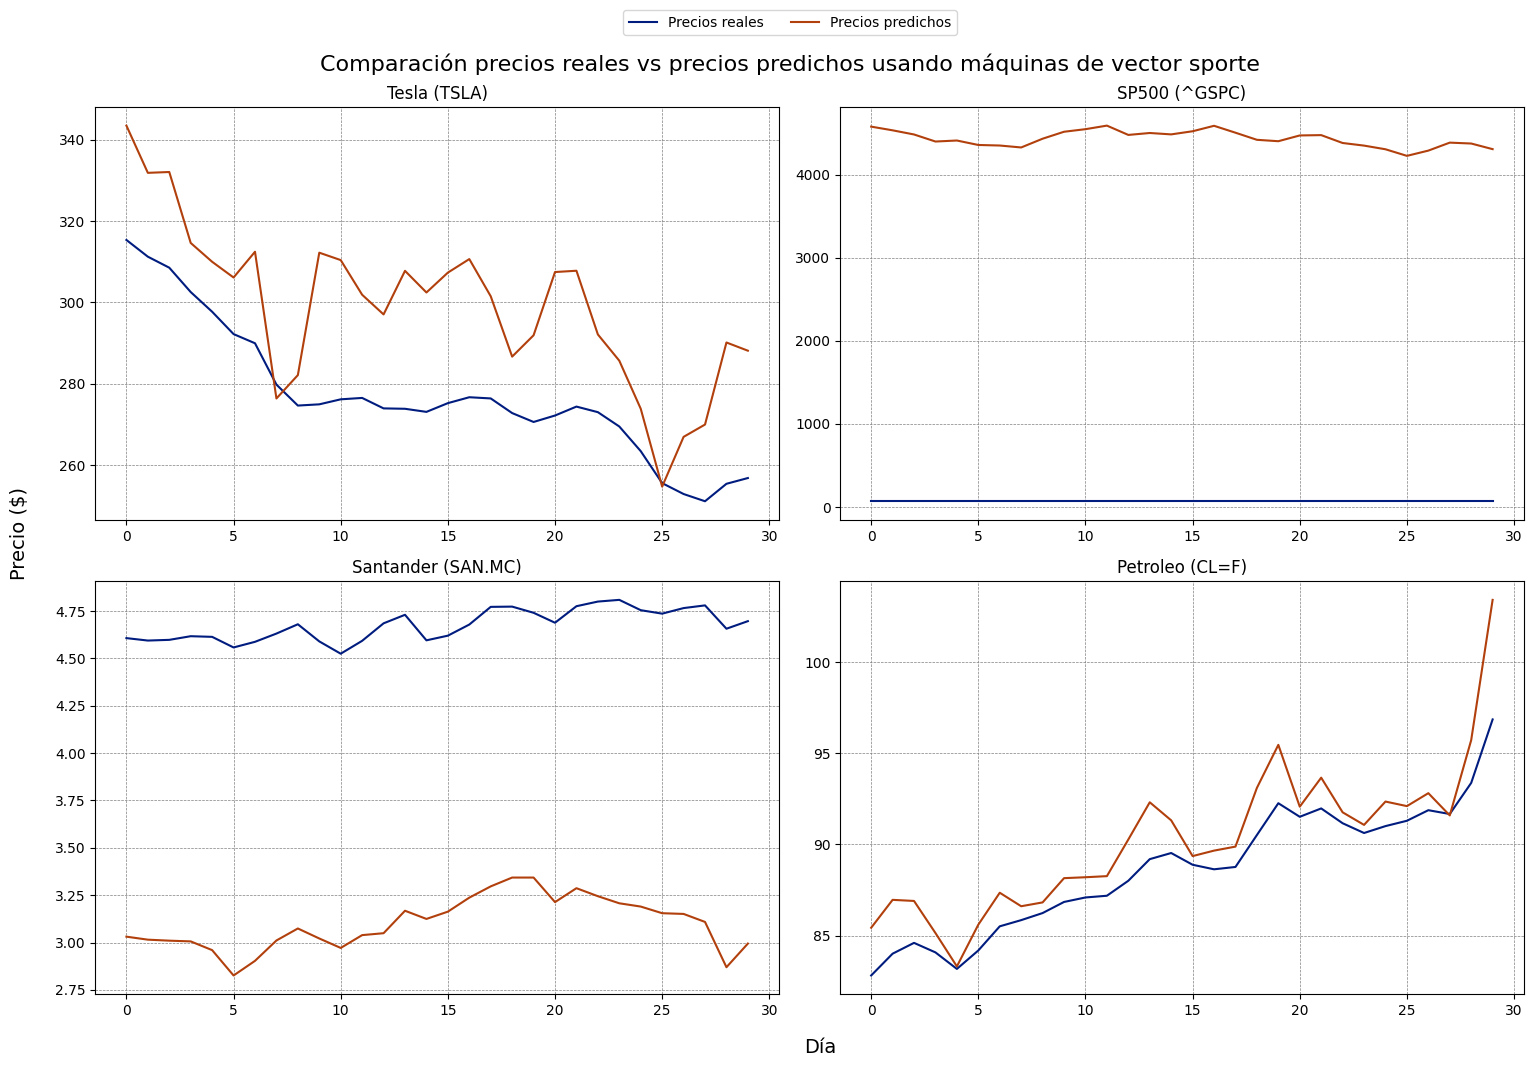

In [297]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_svr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0])

y_pred_sp500_t = model_svr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1])

y_pred_santander_t = model_svr_santander.predict(x_santander_t_reg)
evaluate_model(y_pred_santander_t, y_santander_t, "Santander (SAN.MC)", axs[1, 0])

y_pred_petroleo_t = model_svr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1])

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando máquinas de vector sporte', fontsize=16)
fig.legend(['Precios reales', 'Precios predichos'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 5 días

Tesla (TSLA)
RMSE:  23.006401134981758
MSE:  529.29449318369
MAE:  22.758531797866123
R²:  -3.411257980998853


SP500 (^GSPC)
RMSE:  4410.793858005165
MSE:  19455102.45781609
MAE:  4410.253401359334
R²:  0.0


Santander (SAN.MC)
RMSE:  2.162561821617887
MSE:  4.676673632319273
MAE:  2.1417788039320182
R²:  -53.933620382852055


Petroleo (CL=F)
RMSE:  4.589159077651507
MSE:  21.060381039991228
MAE:  4.393944889678892
R²:  -208.31107104037332




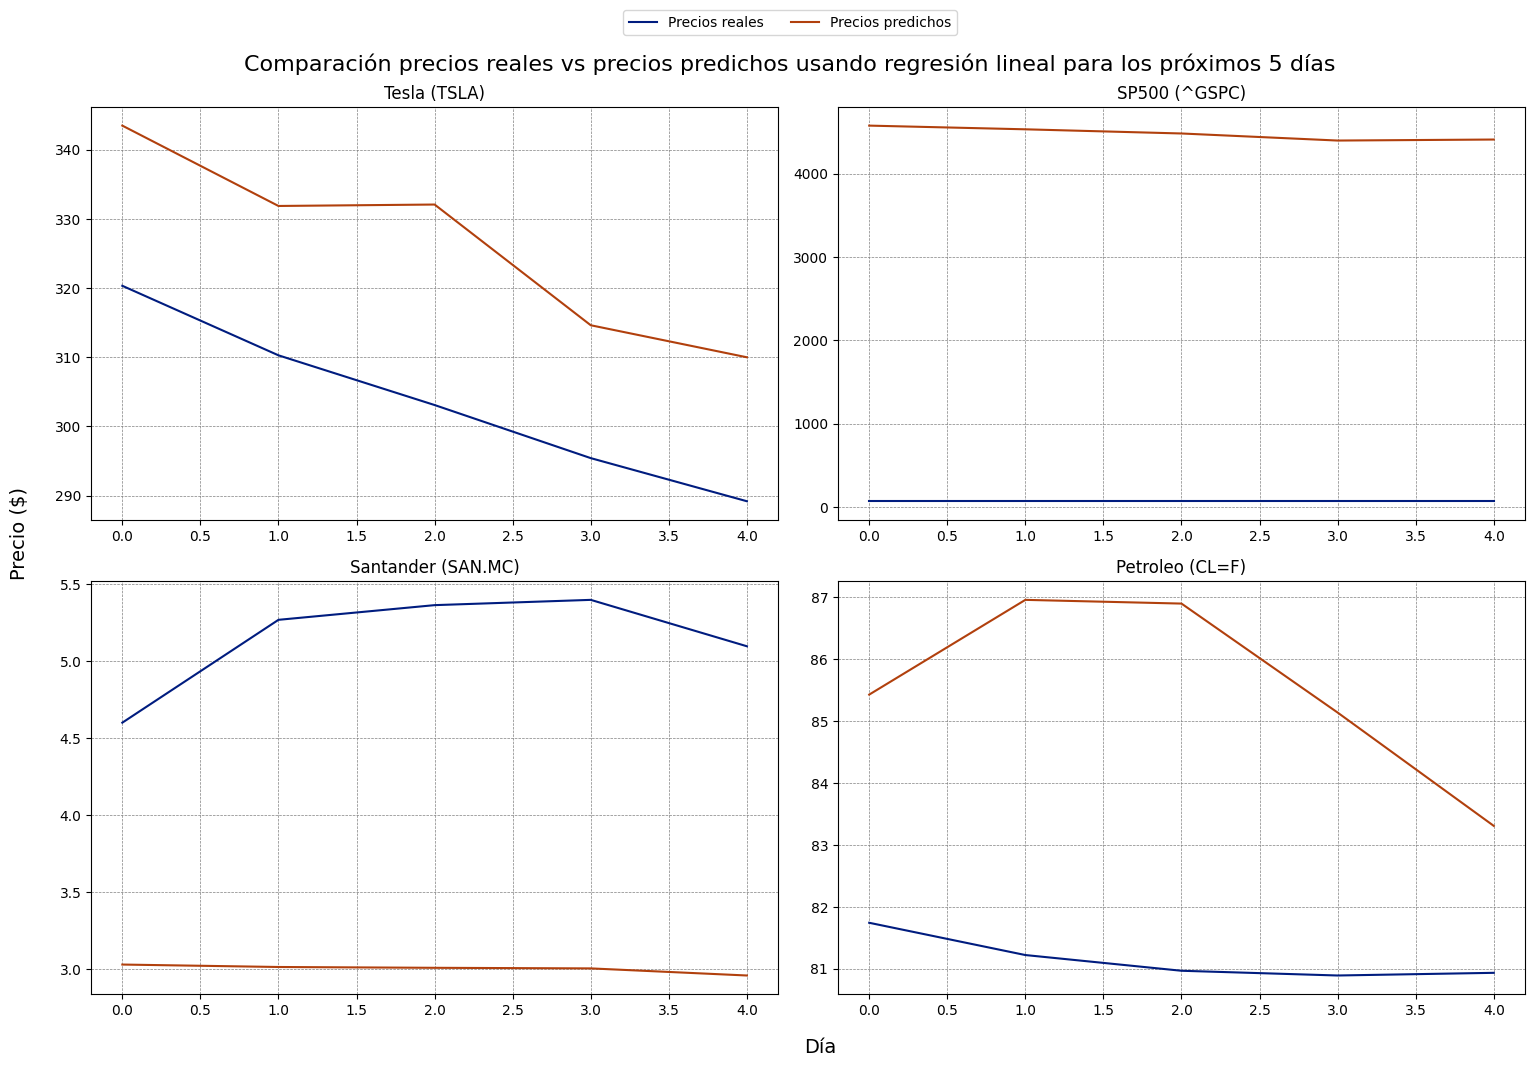

In [298]:
ventana = 10
dias = 5

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], dias)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], dias)

y_pred_santander_t = predict_n_days(datos_santander_test[0:ventana], ventana, dias, model_svr_santander)
evaluate_model_seguidos(y_pred_santander_t, y_santander_t[0:dias], "Santander (SAN.MC)", axs[1, 0], dias)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], dias)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 5 días', fontsize=16)
fig.legend(['Precios reales', 'Precios predichos'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  44.03180629794451
MSE:  1938.7999658597062
MAE:  38.394061913762734
R²:  -1.4845780471614423


SP500 (^GSPC)
RMSE:  4396.028190585615
MSE:  19325063.852423437
MAE:  4395.2955204315285
R²:  -1862021276.7722375


Santander (SAN.MC)
RMSE:  3.0857874041469064
MSE:  9.522083903591703
MAE:  2.988483020714298
R²:  -13.261006096871586


Petroleo (CL=F)
RMSE:  6.288557383024898
MSE:  39.54595395959696
MAE:  5.9290876351945965
R²:  -231.70972534056307




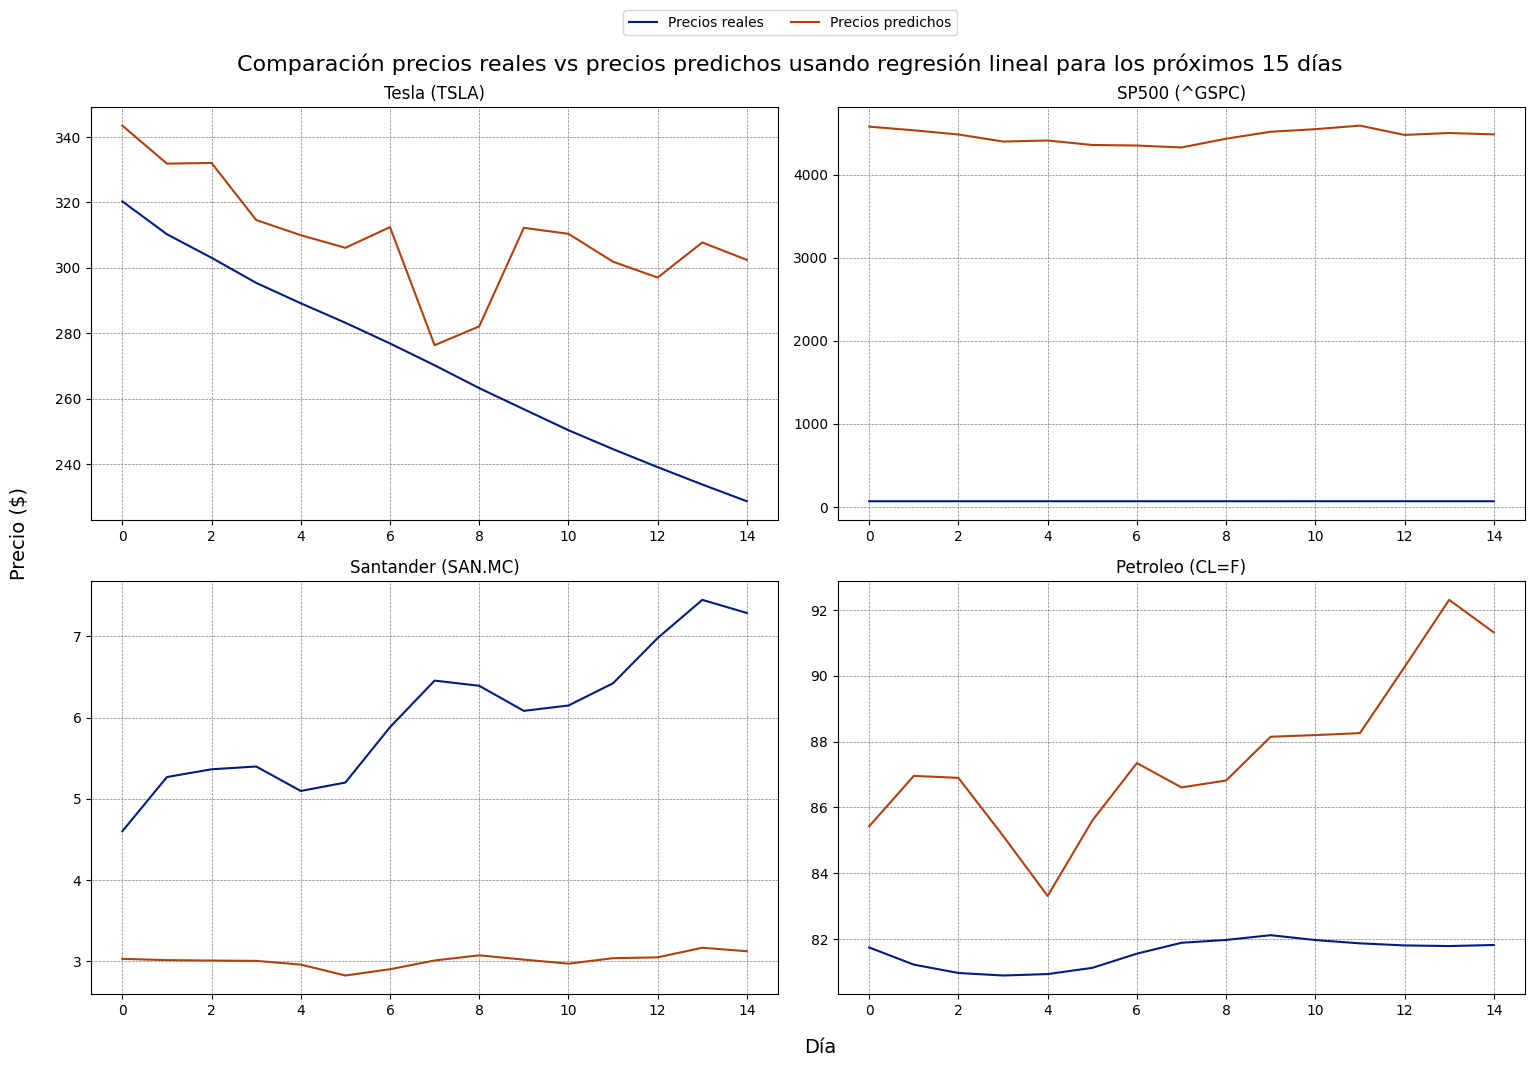

In [299]:
ventana = 10
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], dias)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], dias)

y_pred_santander_t = predict_n_days(datos_santander_test[0:ventana], ventana, dias, model_svr_santander)
evaluate_model_seguidos(y_pred_santander_t, y_santander_t[0:dias], "Santander (SAN.MC)", axs[1, 0], dias)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], dias)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios reales', 'Precios predichos'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM

In [ ]:
# # reshape input to be [samples, time steps, features] which is required for LSTM
# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# print("X_train: ", X_train.shape)
# print("X_test: ", X_test.shape)